# The XY Model

In this project, I will be investigating properties of the XY model using a Monte Carlo simulation. The XY model is a lattice spin model in which each site on the lattice has a 2D unit vector (characterized by an angle). It is defined by the Hamiltonian
$$H = -J\sum_{\langle i,j\rangle} \cos(\theta_i-\theta_j) - h\sum_i \cos(\theta_i)$$

For the purposes of this project, I omitted the Zeeman term by setting $h=0$.

We first import necessary modules. These are all standard, the only one that hasn't been used in class is `multiprocessing`. This allows us to speed up certain calculations by assigning different tasks to different processor cores to be executed simultaneously.

In [1]:
#Import necessary modules
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from multiprocessing import Pool,cpu_count

Now, we define some functions for actually carrying out the simulation.

`createstate` creates a new state, assigning a random spin to each site on an `nx*ny` lattice.

`MCstep` carries out one Monte Carlo step on the state `config`. Rather than iterating through each lattice site one by one, we can significantly speed up the calculation by updating all the even sites simultaneously, followed by updating all the odd sites simultaneously. Because we have restricted ourselves to only nearest neighbor interactions, this still satisfies the Monte Carlo criteria.

`MCMC` carries out the Monte Carlo simulation for the specified amount of steps. It first does `EQsteps` to let the system equilibrate/thermalize, then records the spin states for an additional `MCsteps` iterations.

In [2]:
#Create initial state
def createstate(nx,ny):
    '''
    Creates an initial state for an nx by ny lattice, assigning a random spin (0,2pi) on each site.
    Args: nx and ny (ints)
    Returns: config (nx*ny ndarray of spins)
    '''
    config = 2*np.pi*rand(nx,ny)
    return config

def MCsweep(config,T,J=1.0):
    '''
    Performs a single Monte Carlo sweep on the given configuration with temperature T and coupling constant J.
    Creates a proposed new state and computes deltaE for changing the spin at each site individually. These changes
    are then accepted at each site depending on the Metropolis algorithm.
    Args: config (spins of initial state, array), T (temperature, float), J (coupling constant, float)
    Returns: config (spins of new state, array)
    '''
    
    #Create the new proposed state at every site
    (nx,ny) = np.shape(config)
    newconfig = createstate(nx,ny)
    
    #Computes the energy of the 4 bonds at each lattice site in the original configuration
    E1 = np.cos(config-np.roll(config,1,axis=0)) + np.cos(config-np.roll(config,-1,axis=0)) + np.cos(config-np.roll(config,1,axis=1)) + np.cos(config-np.roll(config,-1,axis=1))
    #Computes the new energy of the 4 bonds at each lattice site if the proposed change is accepted
    E2 = np.cos(newconfig-np.roll(config,1,axis=0)) + np.cos(newconfig-np.roll(config,-1,axis=0)) + np.cos(newconfig-np.roll(config,1,axis=1)) + np.cos(newconfig-np.roll(config,-1,axis=1))
    
    #Computes the change in energy at each lattice site, then accepts change at each even site per the Metropolis algorithm
    delE = -J*(E2-E1)
    p_acc = rand(nx,ny)
    acceptmask = np.logical_and(np.exp(-delE/T) > p_acc,evens)
    config[acceptmask] = newconfig[acceptmask]
    
    #Recomputes the energy of the 4 bonds at each lattice site in the new configuration with updated even sites
    E1 = np.cos(config-np.roll(config,1,axis=0)) + np.cos(config-np.roll(config,-1,axis=0)) + np.cos(config-np.roll(config,1,axis=1)) + np.cos(config-np.roll(config,-1,axis=1))
    #Computes the new energy of the 4 bonds at each lattice site if the proposed change is accepted on odd sites
    E2 = np.cos(newconfig-np.roll(config,1,axis=0)) + np.cos(newconfig-np.roll(config,-1,axis=0)) + np.cos(newconfig-np.roll(config,1,axis=1)) + np.cos(newconfig-np.roll(config,-1,axis=1))
    
    #Computes the change in energy at each lattice site, then accepts change at each odd site per the Metropolis algorithm
    delE = -J*(E2-E1)
    p_acc = rand(nx,ny)
    acceptmask = np.logical_and(np.exp(-delE/T) > p_acc,odds)
    config[acceptmask] = newconfig[acceptmask]
        
    return config

def MCMC(nx,ny,T,EQsteps,MCsteps,J=1.0):
    '''
    Performs a Markov chain Monte Carlo simulation of the system. System is given a specified number of steps to equilibrate
    or thermalize. Then the spins are recorded at each of the next [MCsteps] steps.
    Args: config (initial state, array), T (temperature, float), J (coupling constant, float), EQsteps (number of
          equilibration steps, int), MCsteps (number of recorded steps, int)
    Returns: ens (ensemble of spin states for the final MCsteps steps, MCsteps*nx*ny array)
    '''
    config = createstate(nx,ny)
    #Perform thermalization steps
    for i in range(EQsteps):
        config = MCsweep(config,T,J)
    #Perform recorded simulation steps
    (nx,ny) = np.shape(config)
    ens = np.zeros((MCsteps,nx,ny))
    for i in range(MCsteps):
        config = MCsweep(config,T,J)
        ens[i,:,:] = config   
    return ens

The following functions will compute physical quantities once we have obtained a spin ensemble using the above functions. They all take spin ensembles as input, i.e. a collection of many consecutive lattice states obtained from `MCMC`. They return a 1D array that contains the given quantity computed at each step in Monte Carlo time.

`mag2` computes the squared magentization (per site).

`energy` computes the energy (per site).

`energy2` computes the squared energy (per site) for use in calculating the specific heat.

`specheat` computes the specific heat of the system.

In [3]:
def mag2(ens):
    '''
    Calculates the squared magnetization per site of the system at each time step in an ensemble.
    Args: ens (system state at each step of MC time, MCsteps*nx*ny array)
    Returns: squared magnetization M2 at each time step (array)
    '''
    (steps,nx,ny) = np.shape(ens)
    N = nx*ny
    sx = np.sum(np.cos(ens),axis=(1,2))/N
    sy = np.sum(np.sin(ens),axis=(1,2))/N
    M2 = sx**2 + sy**2
    return M2

def energy(ens):
    '''
    Calculates the energy per site at each time step in an ensemble
    Args: ens (system state at each step of MC time, MCsteps*nx*ny array)
    Returns: energy at each time step (array)
    '''
    (steps,nx,ny) = np.shape(ens)
    N = nx*ny
    
    En = np.cos(ens-np.roll(ens,1,axis=1)) + np.cos(ens-np.roll(ens,-1,axis=1)) + np.cos(ens-np.roll(ens,1,axis=2)) + np.cos(ens-np.roll(ens,-1,axis=2))
    energy = -J*np.sum(En,axis=(1,2))/N
    return energy

def energy2(ens):
    '''
    Calculates the energy per site at each time step in an ensemble
    Args: ens (system state at each step of MC time, MCsteps*nx*ny array)
    Returns: energy at each time step (array)
    '''
    (steps,nx,ny) = np.shape(ens)
    N = nx*ny
    
    En = np.cos(ens-np.roll(ens,1,axis=1)) + np.cos(ens-np.roll(ens,-1,axis=1)) + np.cos(ens-np.roll(ens,1,axis=2)) + np.cos(ens-np.roll(ens,-1,axis=2))
    energy2 = J**2*np.sum(En**2,axis=(1,2))/N
    return energy2

def specheat(ens,T):
    (steps,nx,ny) = np.shape(ens)
    N = nx*ny
    
    c = (energy2(ens)-energy(ens)**2)/(T**2)
    return c
    

Now that we have defined all the functions that we will need, we can carry out the simulation. We want to investigate how various physical properties depend on temperature, so we run multiple simulations over a range of `T` values.

In [4]:
#Specify parameters for the simulation
nx = 32
ny = 32
J = 1
EQsteps = 15000
MCsteps = 1000

#Create masks for even sites and odd sites
evens = np.zeros((nx,ny),dtype=np.bool_)
odds  = np.zeros((nx,ny),dtype=np.bool_)
for i in range(nx):
    for j in range(ny):
        if (i+j)%2==0:
            evens[i,j] = True
        else:
            odds[i,j] = True

#Creates an iterable to pass appropriate arguments to the map function
mapargs = [[nx,ny,T,EQsteps,MCsteps,J] for T in np.linspace(.3,1.5,30)]

#Carry out the simulation and store results as a list whose elements are spin ensembles at different temperatures.
if __name__ == '__main__':
    with Pool(cpu_count()) as p:
        ensT = p.starmap(MCMC,mapargs)

Having carried out the simulation, we can calculate and plot some of the physical attributes of the system. First, the squared magnetization. As temperature increases, $\langle M^2\rangle$ decreases gradually at first, then more steeply before tapering off to zero.

The transition from gradual to steep decrease occurs around $T=.9$, and is known as the Berezinskii-Kosterlitz-Thouless phase transition. This is an infinite order phase transition.

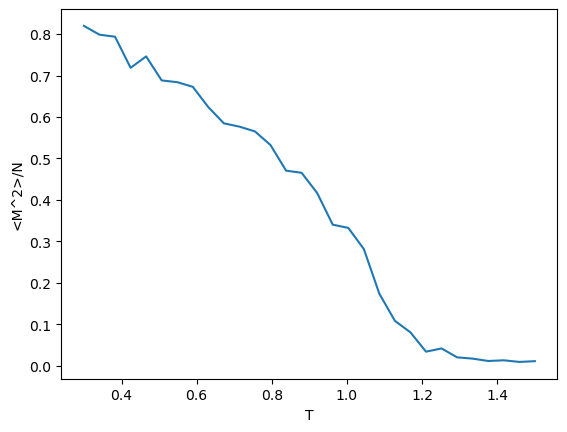

In [5]:
#List of T values on x axis
T = np.linspace(.3,1.5,30)
#Calculate M^2 at each temperature
M2 = [np.mean(mag2(ensT[i])) for i in range(30)]

plt.plot(T,M2)
plt.xlabel('T')
plt.ylabel('<M^2>/N')
plt.savefig('M2.png')

Next, we plot the energy per site. We see that it increases as temperature increases. This makes sense, since higher temperatures lead to more disordered (and thus higher energy) states.

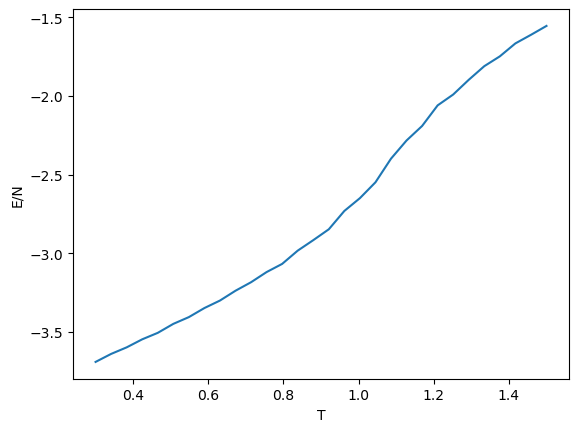

In [6]:
En = [np.mean(energy(ensT[i])) for i in range(30)]
plt.plot(T,En)
plt.xlabel('T')
plt.ylabel('E/N')
plt.savefig('E.png')

Finally, we consider the specific heat. Notably, we find that there is a peak at around $T=1.1$.

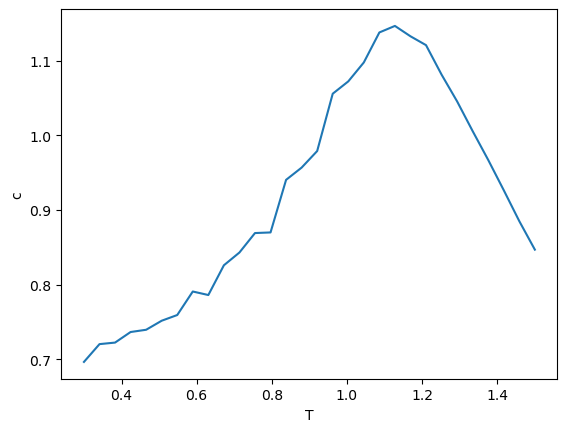

In [7]:
c = [np.mean(specheat(ensT[i],T[i])) for i in range(30)]
plt.plot(T,c)
plt.xlabel('T')
plt.ylabel('c')
plt.savefig('c.png')

It can also be interesting to look at how the system evolves at each step in Monte Carlo time. We will look at two different temperatures, $T=.2$ and $T=1.2$, to see how they differ qualitatively.

In [8]:
#Set system size
nx=ny=128

#Redefine even and odd masks for new system size
evens = np.zeros((nx,ny),dtype=np.bool_)
odds  = np.zeros((nx,ny),dtype=np.bool_)
for i in range(nx):
    for j in range(ny):
        if (i+j)%2==0:
            evens[i,j] = True
        else:
            odds[i,j] = True

#Carry out the two simulations for 250 iterations each
ens1 = MCMC(nx,ny,0.2,0,250)
ens2 = MCMC(nx,ny,1.2,0,250)

First, we animate the $T=.2$ system. We see that it quickly enters a somewhat ordered state, with large blocks of similar colors indicating that the spins in these regions are aligned.

<IPython.core.display.Javascript object>


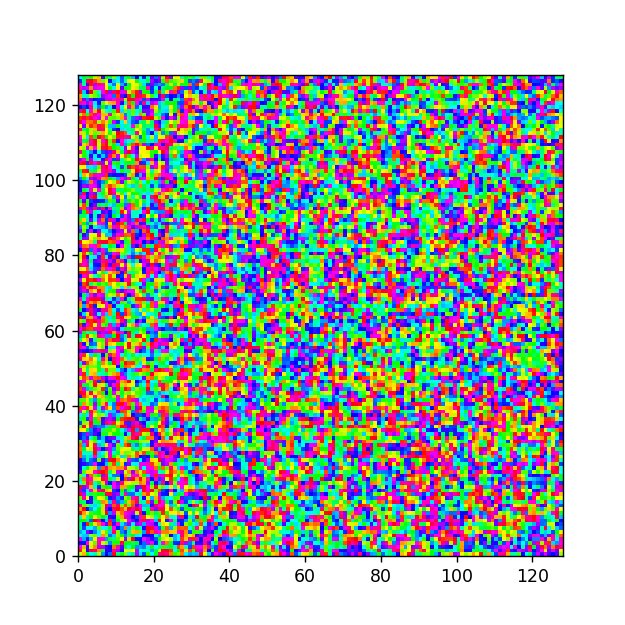

In [9]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

fig,ax = plt.subplots(figsize=(5,5))
cax = ax.pcolormesh(ens1[0,:,:],vmin=0,vmax=2*np.pi,cmap='hsv')

def animate1(i):
    cax.set_array(ens1[i,:,:])

anim = FuncAnimation(fig,animate1,interval=5,frames=200)
plt.show()

We now animate the $T=1.2$ system. Here, we see that the system does not become much more ordered as time goes on. Although very small regions of aligned spins do form, these correlations die off very quickly.

<IPython.core.display.Javascript object>


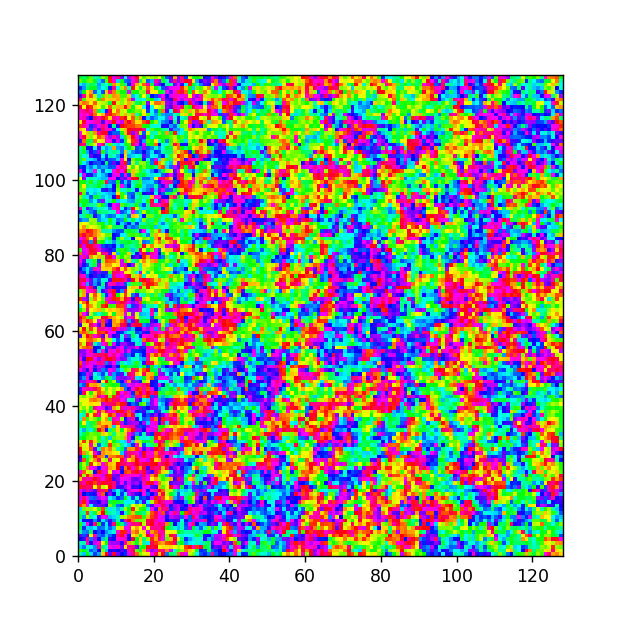

/home/alyx/miniconda3/envs/phys5070/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


In [10]:
fig,ax = plt.subplots(figsize=(5,5))
cax = ax.pcolormesh(ens2[0,:,:],vmin=0,vmax=2*np.pi,cmap='hsv')

def animate2(i):
    cax.set_array(ens2[i,:,:])

anim = FuncAnimation(fig,animate2,interval=5,frames=200)
plt.show()